# 프로젝트 : 폐렴 진단기 성능개선_ver3
### 개요
pneumonia_segmentation.ipynb 파일에서 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기(CNN모델)를 만들어 보았습니다.  
그러나 90% 이상에 도달하는 숙련된 의사분들 유사한 성능을 내기 위하여 Pre-trained 모델을 활용하여 성능을 향상시켜보려 합니다.  
### 목차
#### 1. 실험환경 Set-up
- 패키지들 import
- 필요한 변수 생성
    - 데이터 로드 시 설정 변수 : AUTOTUNE
    - 이미지 사이즈 변수
    - 데이터 경로 변수
    - 파라미터 : BATCH_SIZE, EPOCHS

#### 2. 데이터 준비하기  
    2-1. train, val, test 데이터 살펴보기 : 개수, 비율 확인  
    - train, val, test 디렉토리 내 파일을 각각의 리스트로 변환 및 데이터 개수 확인
    - train, val 데이터의 balance 맞추기 : 하나의 변수에 담아서 섞고, 원하는 비율로 train:val 데이터 나누어 변수에 담기
    - Normal, Pneumonia 데이터 개수 확인 : 데이터 규모 및 balance 확인 (이후 imbalance 조정 작업 필요할지)  
    
    2-2. tf.data 인스턴스 만들기 (mini-batch로 작업할 수 있도록)    
    
    2-2-1. train, val data 전처리
    - train, val 리스트 내의 파일(경로)를 원소로 하는 텐서 생성 -> train, val datasets 만들기
    - train, val datasets size(이미지 개수) 확인 _tensorflow형식의 데이터 포멧
    - 라벨(정답) 데이터 만들기 : train, val, test datasets 모두에 해당. 파일 경로를 활용.   
    (실무에서는 test datasets의 라벨은 알 수 없어서 만들지 않고 진행하는 경우도 있다. __ex.사용자로부터 입력 받을 값인 경우)
    - 이미지 파일의 경로 입력 시 이미지와 라벨을 읽어오는 함수 생성.   
    이미지를 적절한 형식으로 바꾸는 함수 활용   
        - unit8 tensor : 채널 설정
        - tf.float32 : 0~255-> 0~1 사이 숫자로 표준화
        - 이미지 사이즈 : 입력 받은 값으로 적용되도록 설정
    - train, val datasets(내 데이터) 각각에 이미지&라벨 읽어오는 함수와 AUTOTUNE 변수 적용
    - 이미지 Resize, 라벨이 잘 적용되었는지 imshow로 확인   
    
    2-2-2. test data 전처리  
    - test datasets 만들기 :   
    텐서 생성하여 데이터셋 만들기 -> 데이터셋 크기 확인 -> 이미지&라벨 읽어오는 함수, AUTOTUNE 변수, 배치 사이즈 적용 

    2-3. Data Augmentation(데이터 증강)  
    - 좌우 반전과 회전, shuffle(buffer_size), repeat, batch, prefetch
    - train, val datasets 각각에 적용
  
#### 3. 데이터 시각화
- 학습용 데이터를 시각화하여 확인 : 데이터 증강, image resize, label 등

#### 4. ResNet-18 구현
- Residual Block 구성
- ResNet18 model 구현

#### 5. 데이터 imbalance 처리
- NORMAL, PNEUMONIA balance 맞추기 : 가중치 활용

#### 6. 모델 훈련
- GPU를 활용하여 훈련하도록 설정
- model compile, model training
- 추후 모델 활용(성능 향상 등)을 위해 model, history save

#### 7. 결과 확인과 시각화
- 모델 평가 : 평가지표는 accuracy, recall(의료 영상 모델의 특성 상 중요), precision
- 시각화 및 분석

### 회고

### 참조
---

In [1]:
# 주요 라이브러리 버전 확인
import tensorflow

print(tensorflow.__version__)

2.6.0


## 1. 실험환경 Set-up
Batch size, Epoch 등을 변경해봅니다.

In [2]:
# 패키지(라이브러리)들을 import
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# 앞으로 필요한 변수들을 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 파라미터 설정 - epochs을 10 -> 8로 조정
BATCH_SIZE = 16
EPOCHS = 8

# 데이터 경로 print 해보기
print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.  
데이터는 아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

- train
    - NORMAL
    - PNEUMONIA
- test
    - NORMAL
    - PNEUMONIA
- val
    - NORMAL
    - PNEUMONIA

In [4]:
# train, test, validation 각 데이터들의 개수 확인하기

# TRAIN_PATH 내의 모든 파일에 대한 리스트를 반환하여 train_filenames 변수에 할당
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
# TEST_PATH 내의 모든 파일에 대한 리스트를 반환하여 train_filenames 변수에 할당
test_filenames = tf.io.gfile.glob(TEST_PATH)
# VAL_PATH 내의 모든 파일에 대한 리스트를 반환하여 train_filenames 변수에 할당
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 리스트로 저장되어있는 train, test, val 데이터(파일명)들의 개수 확인하기
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# 데이터 리스트 확인해보기
val_filenames

['/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1430-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1442-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1427-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1440-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1437-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1431-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1436-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1438-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1949_bacteria_4880.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1946_bacteria_4874.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1952_bacteria_4883.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1950_bacteria_4881.jpeg',
 '/aiffel/aiffel/chest_xray/data/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
 '/aiffel/aiffel/chest_xray/d

- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.
- 개수 비율은 89%, 10.7%, 0.3% 로 val개수가 너무 적기 때문에 train에서 val에 쓰일 데이터를 더 가져옵니다.
- train, val 데이터를 모은 후 train:val = 80:20으로 분할

In [6]:
# train, validation 데이터의 비율 조정

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)   # 전체 데이터셋에서 80%에 해당하는 훈련 데이터의 크기를 계산. math.floor 함수를 사용하여 소수점 이하를 버림.
random.seed(8)                                # 난수 발생 시드를 8로 설정합니다. 이는 난수 생성의 초기 상태를 지정하는데 사용됨.
random.shuffle(filenames)                     # 리스트 내의 파일 경로들을 무작위로 섞기
train_filenames = filenames[:train_size]      # 섞인 리스트에서 처음부터 훈련 데이터의 크기까지를 선택하여 훈련 데이터셋으로 지정
val_filenames = filenames[train_size:]        # 나머지 부분을 검증 데이터셋으로 지정

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- 80:20으로 분할 결과 train은 4185개, test는 624개, val은 1047개가 되었습니다.
- test_size를 수정하면 개수는 달라질 수 있습니다.

In [7]:
# 정상 이미지와 폐렴 이미지의 구분 방법 찾기 - 파일 경로를 통해 확인해보기
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


- 정상 이미지와 폐렴 이미지의 구분은 파일 경로로 알 수 있습니다. : NORMAL, PNEUMONIA
- 즉, 정상 이미지와 폐렴 이미지의 개수는 파일 경로에 각각 NORMAL, PNEUMONIA이 있는지로 개수를 확인하면 셀 수 있습니다.

In [8]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과 해석하기

- 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.
- CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다.
- 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다.
- test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없습니다.  

### 미니배치로 작업하기 위한 tf.data 인스턴스를 만들기
- tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [9]:
# input 파이프라인 만들기 - 메모리에 있는 데이터로 데이터셋 만들고 텐서 생성
# 데이터셋 형태로 있으면 다양한 형태로 변형하여 활용하기 좋다.

# train_filenames 리스트에 있는 각 파일 경로를 원소로 하는 텐서를 생성하여 훈련 데이터셋을 만듭니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)

# val_filenames 리스트에 있는 각 파일 경로를 원소로 하는 텐서를 생성하여 검증 데이터셋을 만듭니다.
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
# Train 데이터셋, Validation 데이터셋의 크기(이미지 개수) 확인 _중복없는 데이터 개수
# numpy를 활용하면 사람이 보기 편한 형태로 반환된다.

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validation images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validation images count: 1047


> tf.data.experimental.cardinality(
    dataset
)

> 데이터셋을 입력하면 데이터셋의 크기를 반환해준다.

- 현재 이미지에는 라벨 데이터가 따로 없습니다. (학습이 잘 되었는지 확인하기 위한 정답인 라벨이 필요)
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [11]:
# 정답 라벨 데이터를 만들어주는 함수 만들기
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성(폐렴)과 음성(정상)을 구분할 수 있습니다.

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 정상이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.  
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄입니다.  

- decode_img 함수와 process_path 함수를 만들겠습니다.
    - process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다.
    - get_label을 이용해서 라벨 값을 가져옵니다.

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정. 보통 0에서 255 사이의 정수값을 0에서 1 사이의 부동소수점 값으로 조정하는 과정이다.
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다.

- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줄 수 있습니다.

In [13]:
# 데이터셋에 process_path 함수를 적용하기
# 활용한 map()함수가 데이터셋(train_list_ds, val_list_ds)의 각 요소에 함수(process_path)를 적용하여 변환하는 역할

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape: (180, 180, 3)
Image type: <dtype: 'float32'>
Label: False


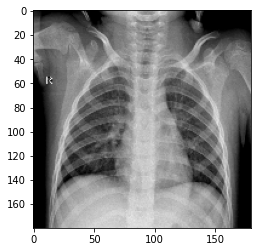

In [14]:
# 이미지 Resize가 잘 되었는지, 라벨이 잘 들어가있는지 확인하기
for image, label in train_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Image type:", image.dtype)
    print("Label:", label.numpy())
    
plt.figure
plt.imshow(image.numpy())

# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

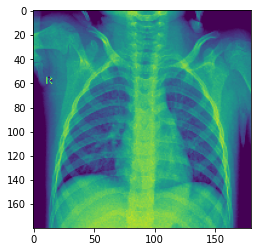

In [15]:
plt.figure()
plt.imshow(image.numpy()[:,:,2])

- train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다.
- 그리고 데이터 개수도 확인하겠습니다.

In [16]:
# test dataset 만들기

# TEST_PATH 디렉토리 내의 모든 파일을 원소로 하는 텐서를 생성하여 테스트 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
# test dataset의 크기(이미지 개수) 확인 _넘파이 배열로 변환하여
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
# 이미지 파일의 경로를 입력하여 이미지와 라벨을 출력하는 함수 & AUTOTUNE 변수 적용
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# 데이터셋을 배치 단위로 묶기
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 따라서 augmentation 기법을 활용해보고자 합니다.   
그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다.   
특히 X-RAY 같은 의료 영상의 특성 상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.  
그래서 augmentation 도입은 신중해야 합니다.

- 다음은 좌우 반전과 회전 augmentation 함수를 생성하여 도입하는 과정입니다.
    - 폐렴을 분간할 수 있는 영역을 해치지 않는 선에서 모델 성능을 향상시킬 수 있는 좌우 반전
    - 생각해보기 : 사람이 항상 똑바른 자세(같은 자세)로 누워서 촬영하지 않을 것이므로 20도 정도 회전을 적용은 어떨지?   
    (항상 같은 자세로 촬영하기 어려운 현실적인 상황과 특히 유아 데이터셋이 있음으로 고려해보았습니다.)

In [17]:
# 좌우 반전 augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)   # 랜덤하게 좌우를 반전합니다.
    return image, label

Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.  
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.  

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데,  
이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.  
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.  
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.  

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에,  
첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [18]:
# prepare_for_training 함수로 데이터 변환 및 파이프라인 세팅

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,      # augment(좌우 반전) 함수 적용
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

map  
- 실행시킨다는 의미
- 실행(적용)시키고자 하는 기능(함수)와 iterable 객체를 받아야 함

num_parallel_calls = worker  
- 한 번에 몇 세트의 데이터를 처리할 수 있는지? 
- 손이 1개인 사람, 손이 2개인 사람, 손이 3개인 사람으로 생각해본다면 손이 여러 개인 사람이 한 번에 더 많은 작업을 할 수 있다.

버퍼  
- 대기 공간, 대기실 (데이터가 어떤 작업 및 처리되기 전에 대기하는 공간)  
- 버퍼 사이즈가 클수록 좋지만, 컴퓨터 사양이 좋지 않다면 적절하게 설정해주어야 한다.  

repeat  
- 1에폭 돌면서 모든 데이터를 활용하여 학습한 뒤 2번째 에폭을 돌 때 다시 데이터를 활용해야 하므로 

precetch  
- 현재 배치의 데이터 학습하는 동안 다음 배치 데이터를 미리 준비시키는 것.  

# 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.  
좌우 반전과 회전 augmentation이 제대로 처리되었는지를 show_batch() 함수를 통해 확인해 봅니다.

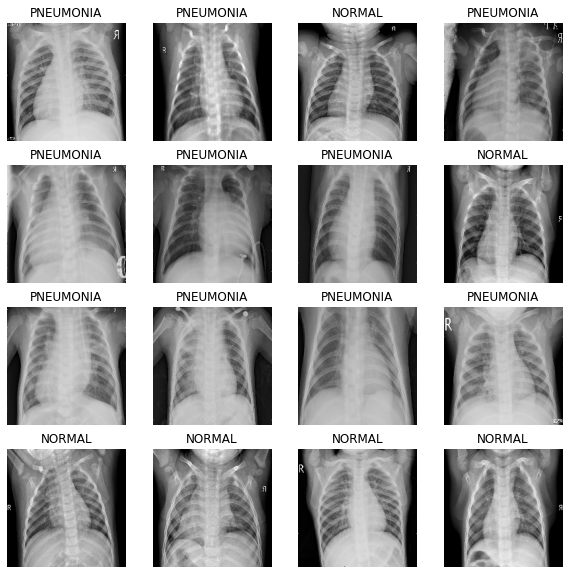

In [19]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여줍니다. _PNEUMONIA, NORMAL 라벨과 함께
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        # math.ceil(BATCH_SIZE/4)는 배치 크기를 4로 나눈 결과를 올림하여 필요한 행의 수를 계산
        # n이 아닌 n+1인 이유 : 인덱스가 0부터 시작하므로 1번째 이미지는 n+1이 되어야 합니다.
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])   # 현재 서브플롯에 이미지를 표시
        
        # 현재 이미지에 대한 라벨이 참(True)이면 ("PNEUMONIA"), 그렇지 않으면 ("NORMAL")
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# 훈련 데이터셋으로부터 하나의 배치를 가져오기 - iter(train_ds)로부터 next함수를 사용하여 다음 배치를 추출
image_batch, label_batch = next(iter(train_ds))
# show_batch 함수를 사용하여 훈련 데이터셋의 일부 이미지를 시각화
show_batch(image_batch.numpy(), label_batch.numpy())

좌우 반전 적용 여부 확인
- 이미지 내의 R표시는 원본 이미지의 경우 좌측에 있습니다.  
- R표시가 우측에 있는 이미지들이 발견되므로 좌우 반전이 적용된 것을 확인할 수 있습니다.  

In [20]:
# 이미지 Resize가 잘 되었는지, 라벨이 잘 들어가있는지 확인하기

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Data type: ", image.dtype)
    print("Label: ", label.numpy())
    
# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

Image shape:  (16, 180, 180, 3)
Data type:  <dtype: 'float32'>
Label:  [ True  True  True  True  True  True False False  True  True  True  True
  True  True False  True]


# 4. ResNet-18 구현
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다.   
Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다.   
ResNet-18은 ResNet의 가장 작은 버전입니다.   

ResNet은 Residual block을 먼저 구성해야 합니다.   
ResNet에서의 weight layer는 아래와 같이 구성되어 있습니다.

1. 3x3 CNN
2. BatchNormalization
3. 활성화 함수 ReLU  

![Residual Block](https://d3s0tskafalll9.cloudfront.net/media/images/residual_connection.max-800x600.png)  

### Residual block 구성하기

In [21]:
# 라이브러리 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model

In [23]:
# skip connection이 구현된 residual_module 함수를 정의
def residual_module(input_layer, n_filters=64, kernel_size=(3,3), strides=(1,1), padding=(1,1)):
    merge_input = input_layer
    # if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
    if input_layer.shape[-1] != n_filters:
        merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filter로 채널 사이즈를 맞춰 준다.

    # 1번째 CNN layer : Conv2D layer, BatchNormalization, Activation(Relu)
    x = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # 2번째 CNN layer : Conv2D layer, BatchNormalization, Activation(Relu)
    x = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)

    # Add를 통해서 skip connection을 구현하는 부분
    out_layer = keras.layers.Add()([x, merge_input])
    out_layer = keras.layers.Activation('relu')(out_layer)

    return out_layer

### ResNet Class 전체 코드
이미지와 같은 Residual block을 구성한 후, 아래와 같이 ResNet을 구현합니다.   
(참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿀 예정입니다.)   
![ResNet 구현](https://d3s0tskafalll9.cloudfront.net/media/images/resnet-18.max-800x600.png)

In [40]:
# ResNet18 모델 구현

def ResNet18(pool_size=7):
    # Input layer 정의 및 residual module 생성
    inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    # conv1
    x = keras.layers.SeparableConv2D(64, kernel_size=(7,7), strides=2, padding='same')(inputs)
    
    # conv2_x의 maxpooling
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # conv2_x : Residual_block
    x = residual_module(x, 64)
    x = residual_module(x, 64)
    
    # con3_x : Residual_block
    x = residual_module(x, 128)
    x = residual_module(x, 128)
    
    # con4_x : Residual_block
    x = residual_module(x, 256)
    x = residual_module(x, 256)
    
    # con5_x : Residual_block
    x = residual_module(x, 512)
    x = residual_module(x, 512)
    
    # Average Pool Layer : 마지막 층
    x = keras.layers.AveragePooling2D(pool_size)(x)
    x = keras.layers.Dense(1000, activation='softmax')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name='resnet18_model')
    
    return model

[참고] 일반적으로  
- kernel_size=(3,3)이면 padding=1
- kernel_size=(5,5)이면 padding=2
- kernel_size=(7,7)이면 padding=3

# 5. 데이터 imbalance 처리
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었습니다.  
한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.  

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다.  
Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.  
Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.  

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다.  
이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [41]:
# weight balancing
# 가중치 = (1/클래스의 샘플 수) x 총 샘플 수 / 2.0
# 1/2.0을 곱해주는 이유는 가중치를 상대적으로 줄이기 위함 -> 만약 이 부분이 없다면, 특히 불균형이 심한 경우에는 어떤 클래스의 샘플이 많아서 그 쪽으로 편향된 학습이 이루어질 수 있다.
weight_for_0 = (TRAIN_IMG_COUNT / COUNT_NORMAL)/2.0 
weight_for_1 = (TRAIN_IMG_COUNT / COUNT_PNEUMONIA)/2.0

# 클래스 0과 클래스 1에 대한 가중치를 딕셔너리로 저장. 이 가중치는 모델 학습 시 사용.
class_weight = {0: weight_for_0, 1: weight_for_1}

In [42]:
# weight 확인하기
print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련
- 이미지 훈련에 GPU를 사용합니다.
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다.
- 성능 향상을 위해 optimizer나 learning rate 등의 변화를 고려해볼 수 있습니다.

In [43]:
# GPU 사용
with tf.device('/GPU:0'):
    resnet_model = ResNet18()
    resnet_model.summary()     # 모델 summary()로 확인

    # 평가 지표 설정
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    # 학습률 설정
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    
    # 모델 컴파일
    resnet_model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "resnet18_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d_4 (SeparableCo (None, 90, 90, 64)   403         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 45, 45, 64)   0           separable_conv2d_4[0][0]         
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 45, 45, 64)   36928       max_pooling2d_4[0][0]            
_____________________________________________________________________________________

- 아래 코드는 훈련된 모델을 재사용하거나 훈련을 처음부터 시작하는 데 사용합니다.
    - 'resnet_model.keras' 파일이 존재하지 않으면, 새로운 훈련이 시작됩니다.
    - 파일이 존재하면, 이전에 저장된 모델과 이력에서 가져온 초기 에폭부터 훈련을 재개합니다.

In [46]:
import pickle 

initial_epoch = 0   # 초기 에포크를 0으로 설정. 이 변수는 훈련을 시작할 때 현재 에포크를 추적하는 데 사용됩니다.

# 'resnet_model.keras' 파일이 존재하는지 확인. 존재한다면 이전에 저장된 모델이 있으므로 훈련을 재개합니다.
if os.path.exists('resnet_model.keras'):
    resnet_model = keras.models.load_model("resnet_model.keras")
    print('Load pretrained ResNet18 model!')
    
    # 이전 훈련에서 사용한 옵티마이저, 손실 함수, 및 메트릭을 사용하여 모델을 다시 컴파일
    resnet_model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history = pickle.load(open('hist.keras', "rb"))   # 이전 훈련의 히스토리 파일을 로드
    initial_epoch = history['epochs']   # 이전 훈련에서 저장된 히스토리에서 마지막 에포크 값을 가져와서 initial_epoch에 설정
    print(f'Resume training from {initial_epoch}')
    
    # 이전 훈련에서 저장된 마지막 에포크 값에 현재 설정된 총 에포크 수를 더하여 전체 에포크 수를 설정. 이는 훈련을 이어서 진행하기 위함.
    epochs = EPOCHS + initial_epoch
    
# 'resnet_model.keras' 파일이 존재하지 않는 경우, 처음부터 새로운 훈련을 시작하므로 전체 에포크 수를 EPOCHS로 설정
else:
    epochs = EPOCHS

Load pretrained ResNet18 model!
Resume training from 2


In [48]:
# GPU를 활용하여 모델 학습 (history)

with tf.device('/GPU:0'):
    history = resnet_model.fit(
        train_ds,
      steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=epochs,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        initial_epoch=initial_epoch,
    )

Epoch 3/10
261/261 [==============================] - 97s 341ms/step - loss: 0.1081 - accuracy: 0.9574 - precision: 0.9861 - recall: 0.9562 - val_loss: 0.1139 - val_accuracy: 0.9519 - val_precision: 0.9496 - val_recall: 0.9869
Epoch 4/10
261/261 [==============================] - 90s 346ms/step - loss: 0.0954 - accuracy: 0.9643 - precision: 0.9888 - recall: 0.9630 - val_loss: 0.1128 - val_accuracy: 0.9510 - val_precision: 0.9890 - val_recall: 0.9435
Epoch 5/10
261/261 [==============================] - 91s 347ms/step - loss: 0.1058 - accuracy: 0.9564 - precision: 0.9857 - recall: 0.9552 - val_loss: 0.1687 - val_accuracy: 0.9356 - val_precision: 0.9741 - val_recall: 0.9372
Epoch 6/10
261/261 [==============================] - 91s 348ms/step - loss: 0.0880 - accuracy: 0.9665 - precision: 0.9891 - recall: 0.9656 - val_loss: 0.3677 - val_accuracy: 0.8510 - val_precision: 0.9919 - val_recall: 0.8037
Epoch 7/10
261/261 [==============================] - 91s 348ms/step - loss: 0.1022 - accura

In [49]:
# model save

# 히스토리 딕셔너리를 얻어 hist에 저장
hist = history.history        # 이 딕셔너리는 에포크별로 훈련 손실, 훈련 정확도, 검증 손실, 검증 정확도 등의 지표를 포함
hist.update(history.params)   # 히스토리 딕셔너리에 히스토리의 파라미터를 업데이트
with open('hist.keras', 'wb') as fid:
    pickle.dump(hist, fid)
    
# 업데이트된 히스토리 딕셔너리를 'hist.keras' 파일로 저장. 이 파일을 fid라는 이름으로 사용하겠다는 의미.
# 'wb': 이진 쓰기 모드로 파일을 열어서 저장합니다.
# pickle.dump() 함수를 사용하여 객체를 직렬화하여 파일에 저장
# hist: 저장할 딕셔너리나 객체 / fid: 파일을 가리키는 파일 객체
    
        
# del resnet_model
# history = pickle.load(open('hist.keras', "rb"))
print(hist)

# 훈련된 모델을 'resnet_model.keras' 파일로 저장
resnet_model.save("resnet_model.keras", overwrite=True)  # overwrite=True 옵션을: 이미 존재하는 파일이면 덮어쓰기를 수행
print('Model saved.')
# del resnet_model

{'loss': [0.10811817646026611, 0.09539729356765747, 0.10580917447805405, 0.08797641098499298, 0.1022195965051651, 0.08912243694067001, 0.07798420637845993, 0.08028170466423035], 'accuracy': [0.9573754668235779, 0.9643199443817139, 0.9564176201820374, 0.9664750695228577, 0.9602490663528442, 0.9655172228813171, 0.9698275923728943, 0.9671934843063354], 'precision': [0.986060380935669, 0.9887788891792297, 0.9856953024864197, 0.9891160726547241, 0.9887305498123169, 0.9897520542144775, 0.9898227453231812, 0.9907468557357788], 'recall': [0.9562278985977173, 0.9630343914031982, 0.9551901817321777, 0.9655505418777466, 0.9576243758201599, 0.9636304974555969, 0.9694533944129944, 0.9649178981781006], 'val_loss': [0.11390988528728485, 0.112764872610569, 0.16867928206920624, 0.367654025554657, 0.08871575444936752, 0.9805603623390198, 1.0013511180877686, 0.27511051297187805], 'val_accuracy': [0.9519230723381042, 0.9509615302085876, 0.9355769157409668, 0.8509615659713745, 0.9653846025466919, 0.7749999

- model 저장
    - API : model.save() 또는 tf.keras.models.save_model()
    - 저장되는 내용
        - 모델의 아키텍처 및 구성
        - 훈련 중에 학습된 모델의 가중치 값
        - 모델의 컴파일 정보(compile()이 호출된 경우)
        - 존재하는 옵티마이저와 그 상태(훈련을 중단한 곳에서 다시 시작할 수 있게 해줌)
    - 확장자
        - save_format='h5'를 save()로 전달합니다.
        - .h5 또는 .keras로 끝나는 파일명을 save()로 전달합니다.

# 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅니다.   
우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다.   
훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해봅니다.

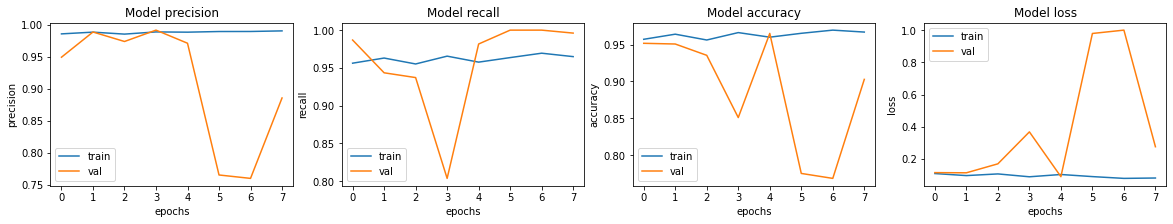

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()   # 1차원 배열로 변환 _각 서브플롯에 쉽게 접근할 수 있도록

# 인덱스(i)와 메트릭 이름(met)을 의미
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

결과 해석  
- train accuracy는 1에 가깝고, train loss는 0.1에 가까운 수치를 보입니다.
- val accuracy는 변동폭이 크며 점점 하락하고, val loss 또한 변동폭이 크게 상승과 하락을 반복합니다.
- epochs이 2~3 일 때 Accuracy가 하락, loss가 상승, recall이 하락하기 시작하는 시점으로 보입니다. (비교적 큰 폭으로)
- 위의 지점에서 오버피팅이 발생한 것으로 보입니다.

개선 방향
- 오버피팅이 발생하기 전에 학습을 멈출 수 있도록 early stopping을 활용해보기
- 학습률을 0.001에서 0.01로 조정하여 학습해보기

---
## 회고
### KEEP
- 첫 시도에서 ResNet18 모델 구현이 어려웠으므로
    - 전체 과정을 단계 별로 정리해보며 구체적으로 어떤 것들이 필요한지 파악해보았다.
    - 각 단계에서 모든 코드에 대하여 확실히 알지 못하는 부분은 모두 주석을 달며 각 단계와 코드를 리마인드 하였다.
- 문제 해결을 위한 구글링에서의 변화
    - stackoverflow, git 등의 사례들과 공식문서를 최대한 활용 및 적용해보았다.
    - 코드에 익숙해지고, 명확한 의미 인식을 위해 최대한 영어로 읽고 이해해보고자 하였다. (번역이 오히려 의미를 오해하게 하는 경우가 있으므로)

### PROBLEM
- trainig 결과를 시각화해보았을 때 train, val curve의 트렌드가 유사하지 않았다.
- 전체 과정을 코드로 구현하며 파악하는 단계이다 보니 파라미터 변경, 학습 기술 적용 등이 낯설고 어렵다.

### TRY
- training curve를 더 구체적이고 명확하게 해석할 수 있도록 자료 찾아보기
- 전체 과정을 개념적으로 더 확실하게 암기, 각 단계에서 필요한 주요 코드 암기, 파라미터 변경과 학습 기술을 어떻게 적용하는지 찾아보고 적용해보기
- 구글링에 더 익숙해지도록
    - 다양한 키워드를 활용하여 적극적으로 활용해보기
    - 공식문서, stackoverflow, git, hugging face 등 일반 블로그에 비해 신뢰할만한 코드 활용해보기

## Reference
- [결과 그래프 해석](https://dataplay.tistory.com/32)
- [google loss curve 분석](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=ko)
- [loss curve 별 조치](https://hyen4110.tistory.com/12)